<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "4G"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/4G/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


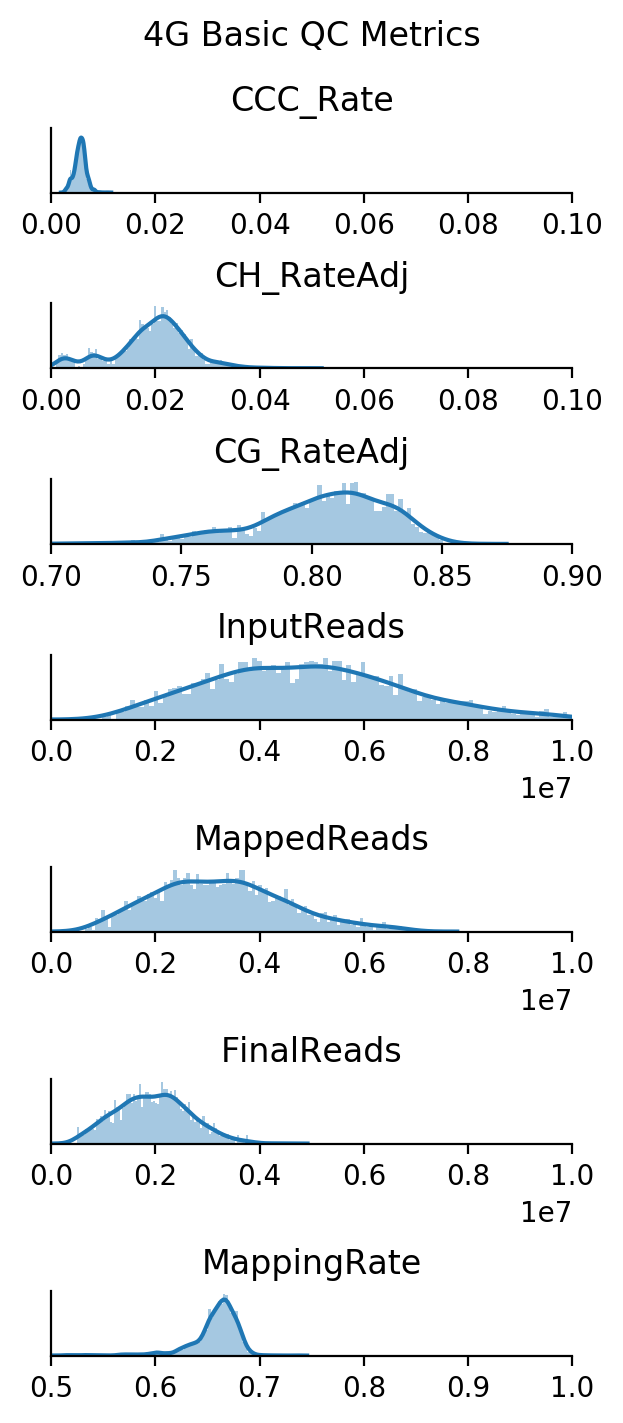

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

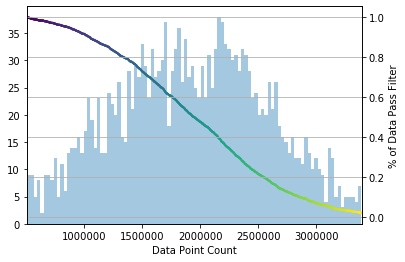

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1967/1967 (100.0%)
CG_RateAdj passed 1967/1967 (100.0%)
CH_RateAdj passed 1967/1967 (100.0%)
FinalReads passed 1967/1967 (100.0%)
MappingRate passed 1967/1967 (100.0%)
Overall passed 1967/1967 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180917 1011
181204 956


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 44 11.5%
ad002 256 66.7%
ad004 253 65.9%
ad006 255 66.4%
ad007 292 76.0%
ad008 296 77.1%
ad010 280 72.9%
ad012 291 75.8%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
4G_M_0,/gale/raidix/rdx-4/mapping/4G/CEMBA180917-4G-5...,0.004658,0.807530,0.806629,0.022451,0.017877,1822510.0,4382920,2897882.0,4G,...,-4.001987,5.149117,-19.365514,-3.110805,LSX-Inh Enox1,3.324259,9.433825,12.655997,14.572974,True
4G_M_1,/gale/raidix/rdx-4/mapping/4G/CEMBA180917-4G-5...,0.006687,0.817310,0.816080,0.033442,0.026935,1858890.0,4463698,2980469.0,4G,...,24.618790,12.625934,-23.109816,-46.362148,CT-L6 Megf9,3.168716,-17.772718,8.765492,-40.700981,True
4G_M_10,/gale/raidix/rdx-4/mapping/4G/CEMBA180917-4G-5...,0.004915,0.801120,0.800138,0.022831,0.018004,1908577.0,4350878,2642716.0,4G,...,-4.414582,1.617162,-26.823872,10.580085,LSX-Inh Cacna1i,9.086990,3.797759,-16.508385,-25.851065,True
4G_M_100,/gale/raidix/rdx-4/mapping/4G/CEMBA180917-4G-5...,0.004943,0.801207,0.800220,0.023374,0.018523,3141151.0,8409448,5664118.0,4G,...,-6.775265,5.420704,-9.323156,-7.726044,LSX-Inh Dock10,8.270651,10.587081,-1.856267,9.207302,True
4G_M_1001,/gale/raidix/rdx-4/mapping/4G/CEMBA180917-4G-7...,0.005738,0.821459,0.820429,0.026740,0.021123,1468940.0,3593580,2378372.0,4G,...,-3.883868,2.040145,-31.175711,7.756719,LSX-Inh Cacna1i,10.761690,1.565878,-26.935855,-23.622744,True
4G_M_1002,/gale/raidix/rdx-4/mapping/4G/CEMBA180917-4G-7...,0.005568,0.803185,0.802083,0.025885,0.020431,2045224.0,4923536,3353684.0,4G,...,-7.572530,6.182909,-7.634076,-10.883963,LSX-Inh Zeb2,12.449520,13.879465,-10.881789,15.193215,True
4G_M_1003,/gale/raidix/rdx-4/mapping/4G/CEMBA180917-4G-7...,0.006114,0.822634,0.821543,0.031367,0.025408,914881.0,2221526,1495300.0,4G,...,-5.580530,4.066219,-12.833720,-0.589757,LSX-Inh Dock10,8.217286,9.367674,0.356749,-9.196020,True
4G_M_1004,/gale/raidix/rdx-4/mapping/4G/CEMBA180917-4G-7...,0.005067,0.826058,0.825173,0.023901,0.018930,1092415.0,2748140,1804683.0,4G,...,-4.377352,4.054650,-16.910483,0.940941,LSX-Inh Nxph1,3.266800,12.737893,21.348967,-7.387039,True
4G_M_1005,/gale/raidix/rdx-4/mapping/4G/CEMBA180917-4G-7...,0.005925,0.826200,0.825164,0.027059,0.021260,1089396.0,2725188,1782586.0,4G,...,-5.664897,3.835823,-12.168099,-2.892065,LSX-Inh Dock10,8.014570,7.576929,-1.548732,-19.086256,True
4G_M_1006,/gale/raidix/rdx-4/mapping/4G/CEMBA180917-4G-7...,0.005177,0.806050,0.805041,0.024026,0.018947,1024742.0,2537986,1712224.0,4G,...,-5.129412,3.864088,-26.324730,3.447990,LSX-Inh Cacna1i,7.064898,6.326181,5.136037,7.076578,True
